# Importing libraries

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-08-20 23:37:19.465971: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-08-20 23:37:19.497850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-20 23:37:19.498170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-08-20 23:37:19.498346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-20 23:37:19.499750: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-20 23:37:19.501048: I tensorflow/st

If uncommented it will print all the log information about where the tensorflow operations were performed, in the CPU or the GPU

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

# Loading the train data set

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [4]:
def my_crop(img, start_y, start_x, desired_height, desired_width):
  if K.image_data_format() == 'channels_last':
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    dy = desired_height #input desired output size
    dx = desired_width #input desired output size
    # start_y = (height-dy)//2
    # start_x = (width-dx)//2
    return img[start_y:start_y+dy, start_x:(dx+start_x), :]
  else:
      assert img.shape[0] == 3
      dy = desired_height #input desired output size
      dx = desired_width #input desired output size
      # start_y = (height-dy)//2
      # start_x = (width-dx)//2
      return img[:,start_y:start_y + dy, start_x:(dx + start_x)]

def crop_augmented_generator(batches, start_y, start_x, crop_height, crop_width):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
    
      if K.image_data_format() == 'channels_last':
        # print("type of batch_x: ", type(batch_x))
        # print("type of batch_y: ", type(batch_y))
        # print("len of batch_x: ", len(batch_x))

        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], crop_height, crop_width, 3))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], crop_height, crop_width, 3))
      else:
        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], 3, crop_height, crop_width))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], 3, crop_height, crop_width))

      for i in range(batch_x[0].shape[0]):
        #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
        batch_crops_input_x[i] = my_crop(batch_x[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_x[i] = my_crop(batch_x[1][i], start_y, start_x, crop_height, crop_width)

        batch_crops_input_y[i] = my_crop(batch_y[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_y[i] = my_crop(batch_y[1][i], start_y, start_x, crop_height, crop_width)
      
      # print(type(batch_crops_input_x))
      batch_crops_x = (batch_crops_input_x, batch_crops_target_x)
      batch_crops_y = (batch_crops_input_y, batch_crops_target_y)

      yield (batch_crops_x, batch_crops_y)

  
    
def crop_generator(batches, start_y, start_x, crop_height, crop_width, flag=0):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
      if flag==0:
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
          batch_crops_y = np.zeros((batch_y.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
          batch_crops_y = np.zeros((batch_y.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
            batch_crops_y[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
        yield (batch_crops, batch_crops_y)
      else: 
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)

        yield (batch_crops, batch_y)
         

In [5]:
# batch_size = 64
batch_size = 10
train_datagen = ImageDataGenerator(rescale=1./255,
                                    brightness_range=[0.88,1.0]) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals and changing the brightness


original_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )

# Generate original images from the original data directory
original_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",
    batch_size=batch_size,
    shuffle = False,
    class_mode='input')

# Combine the generators using the `keras.preprocessing.image.Iterator` class
combined_generator = zip(train_generator, original_generator)

Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.


In [6]:
validation_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 20 images belonging to 1 classes.


In [7]:
validation_generator_for_threshold = original_datagen.flow_from_directory(
    "../../Images/june5Night/Validation/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


In [8]:
test_set_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Creating the cropped images

In [9]:
HEIGHT = 160
WIDTH = 128

In [10]:
train_crops = crop_augmented_generator(combined_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
val_crops = crop_generator(validation_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
test_crops = crop_generator(test_set_generator, 65, 69, HEIGHT,WIDTH,1)      # top, left, height, width
val_crops_for_threshold = crop_generator(validation_generator_for_threshold, 65, 69, HEIGHT,WIDTH,1)      # top, left, height, width

Here we make sure that both of the returned elements of the cropped generator, that is "imgaes_in_batch" and "imgaes_in_batch2", are indeed cropped images.

In [11]:
images_in_batch, images_in_batch2 = next(train_crops)

In [12]:
batch_input_images1 = images_in_batch[0]
batch_expected_images1 = images_in_batch[1]
print(batch_input_images1.shape)
print(batch_expected_images1.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


In [13]:
batch_input_images2 = images_in_batch2[0]
batch_expected_images2 = images_in_batch2[1]
print(batch_input_images2.shape)
print(batch_expected_images2.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


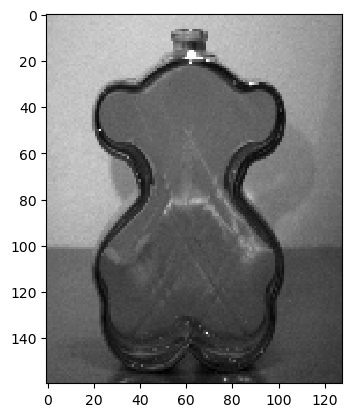

In [14]:
single_img_batch1 = batch_input_images1[0]
plt.imshow(single_img_batch1)

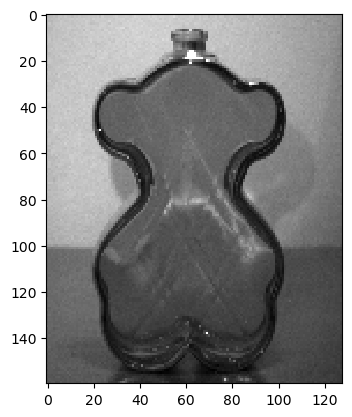

In [15]:
single_img_batch2 = batch_input_images2[0]
plt.imshow(single_img_batch2)

In [16]:
compareImgs = single_img_batch1==single_img_batch2
res1 =  np.all(compareImgs)
print("This is comparisson imgs:", res1)

This is comparisson imgs: False


# Building the model Autoencoder model

In [17]:
latent_dim = 40  # Number of latent dimension parameters

input_img = Input(shape=(HEIGHT, WIDTH, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(80, activation='relu')(x)        # Activation function is supposed to be none, i.e the output is the same as the input

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

2023-08-20 23:37:20.066187: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-08-20 23:37:20.091113: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-08-20 23:37:20.091531: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa54c001020 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-20 23:37:20.091546: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-20 23:37:20.162874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-20 23:37:20.163304: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4fe8f60 initialized for platform CUDA (this does not guarantee that XLA will

(None, 10, 8, 1)
(None, 40)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (Non

In [18]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(10*8*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(320, activation='sigmoid', name="original_decoder")(x)
x = Reshape((10,8,4),input_shape=(320,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 320)               13120     
_________________________________________________________________
original_decoder (Dense)     (None, 320)               102720    
_________________________________________________________________
reshape (Reshape)            (None, 10, 8, 4)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 8, 3)          111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 20, 16, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 16, 3)         84  

In [19]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mean_squared_error')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0   

# Training the model

In [20]:
# # from tensorflow.keras.callbacks import EarlyStopping
# # run the modelvalidat
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=5, mode='auto')
# history = ae.fit(train_crops, epochs=300, steps_per_epoch=len(train_generator)*2, validation_data=val_crops, validation_steps =len(validation_generator),  verbose=1, shuffle = True)

In [21]:

# # Get the training and validation loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Plot the training and validation loss
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


Saving the train and validation history data

In [22]:
# # open file
# with open('txtFilesAutoencoderBottles4/TrainingLoss.txt', 'w+') as g:
#     # write elements of list
#     for items in train_loss:
#         g.write('%s\n' %items)
#     print("train_loss written successfully")
# # close the file
# g.close() 

# # open file
# with open('txtFilesAutoencoderBottles4/ValidationLoss.txt', 'w+') as g:
#     # write elements of list
#     for items in val_loss:
#         g.write('%s\n' %items)
#     print("val_loss written successfully")
# # close the file
# g.close()


LOading the train and validation history data

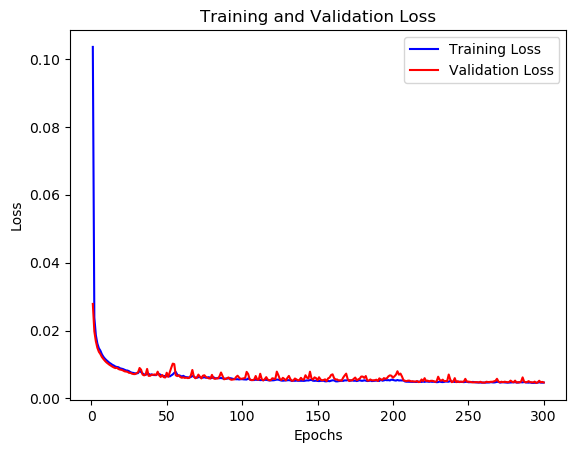

In [23]:
# Load data from the text file
with open("txtFilesAutoencoderBottles6/TrainingLoss.txt", "r") as file:
    train_loss_data = [float(line.strip()) for line in file]

# Load data from the text file
with open("txtFilesAutoencoderBottles6/ValidationLoss.txt", "r") as file:
    val_loss_data = [float(line.strip()) for line in file]

# Plot the training and validation loss
epochs = range(1, len(train_loss_data) + 1)
plt.plot(epochs, train_loss_data, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_data, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
filepath = "models/Bottles6_playground"

In [25]:
# ae.save(f"{filepath}")

Loading the model that was previously saved


In [26]:
# VAE model statement
model = Model(input_img,z_decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0   

In [27]:
model = keras.models.load_model(f'{filepath}')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


## Updating the weights of the Encoder part

In [28]:
# Copy the layer weights from the base model to the target model
for i, target_layer in enumerate(encoder.layers):
    base_layer = model.layers[i]
    target_layer.set_weights(base_layer.get_weights())

# Verify if the weights are successfully copied
for base_layer, target_layer in zip(model.layers[:len(encoder.layers)], encoder.layers):
    base_weights = base_layer.get_weights()
    target_weights = target_layer.get_weights()
    for base_weight, target_weight in zip(base_weights, target_weights):
        if (base_weight == target_weight).all():
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


These are the weights of a specific layer of the encoder model, AFTER copying the weights to it:

In [29]:
layer_number = 12
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  13
The weigths in the dense_1 is:  [<tf.Variable 'dense_1/kernel:0' shape=(80, 40) dtype=float32, numpy=
array([[-0.10400404,  0.18159233,  0.01976633, ..., -0.15218487,
         0.19475651, -0.09854026],
       [ 0.22833656,  0.17342216, -0.02287393, ..., -0.20419474,
         0.13762209, -0.03142049],
       [-0.1468062 , -0.21499439, -0.18412386, ..., -0.13933845,
         0.22378954,  0.03899439],
       ...,
       [-0.0008612 ,  0.15655415,  0.00049293, ..., -0.10853784,
         0.10118984, -0.00136194],
       [-0.00361612, -0.17145923, -0.06309832, ...,  0.14783414,
         0.05033498, -0.23842335],
       [ 0.01847731, -0.16843192, -0.23643282, ..., -0.0749932 ,
         0.18300717, -0.0891355 ]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(40,) dtype=float32, numpy=
array([-0.01439496,  0.0337229 , -0.01796746,  0.0063692 , -0.0821178 ,
       -0.1274954 ,  0.10440206,  0.04213955, -0.10308536,  0.05990963,
       -0.0848579 ,  0.

These are the weights of the same specific layer of the Autoencoder model, AFTER copying its weights:

In [30]:
print("quantity of layers in the model: ", len(model.layers))
print("The weigths in the", model.layers[layer_number].name, "is: ", model.layers[layer_number].weights)

quantity of layers in the model:  14
The weigths in the dense_1 is:  [<tf.Variable 'dense_1/kernel:0' shape=(80, 40) dtype=float32, numpy=
array([[-0.10400404,  0.18159233,  0.01976633, ..., -0.15218487,
         0.19475651, -0.09854026],
       [ 0.22833656,  0.17342216, -0.02287393, ..., -0.20419474,
         0.13762209, -0.03142049],
       [-0.1468062 , -0.21499439, -0.18412386, ..., -0.13933845,
         0.22378954,  0.03899439],
       ...,
       [-0.0008612 ,  0.15655415,  0.00049293, ..., -0.10853784,
         0.10118984, -0.00136194],
       [-0.00361612, -0.17145923, -0.06309832, ...,  0.14783414,
         0.05033498, -0.23842335],
       [ 0.01847731, -0.16843192, -0.23643282, ..., -0.0749932 ,
         0.18300717, -0.0891355 ]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(40,) dtype=float32, numpy=
array([-0.01439496,  0.0337229 , -0.01796746,  0.0063692 , -0.0821178 ,
       -0.1274954 ,  0.10440206,  0.04213955, -0.10308536,  0.05990963,
       -0.0848579 ,  0.

In [31]:
encoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0     

In [32]:
num_features = 40

## Obtaining the KDE representation of the training set images 

In [33]:
def calc_encoded_imgs(batch_images):   
    encoded_imgs_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        encoded_imgs_list.append(encoded_img)   
    return encoded_imgs_list

In [34]:
encoded_imgs_list = []

for i in range(len(train_generator)):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_in_batch2 = next(train_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    batch_input_images1 = images_in_batch[0]
    encoded_imgs_list.append(calc_encoded_imgs(batch_input_images1))
    batch_input_images2 = images_in_batch2[0]
    encoded_imgs_list.append(calc_encoded_imgs(batch_input_images2))
print("The list of rec. error contains ", len(encoded_imgs_list), "batches of rec. errors")

2023-08-20 23:37:22.484115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-20 23:37:22.693332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


The list of rec. error contains  60 batches of rec. errors


In [35]:
encoded_imgs_training = [item for sublist in encoded_imgs_list for item in sublist]
print(len(encoded_imgs_training))

590


In [36]:
encoded_imgs_training = np.array(encoded_imgs_training)
encoded_imgs_training = encoded_imgs_training.reshape(encoded_imgs_training.shape[0],encoded_imgs_training.shape[2])
print(encoded_imgs_training.shape)

(590, 40)


See that it is 590 length because it corresponds to all the images that belong to the training dataset multiplied by 2. Because it is considering as well the feature vector of those augmented images. The second length corresponds to the output shape of the model as specified in its structure at the beginning. For this case, we stated to work with 40 features.

See that it is not the exactly the same as computing directly the encoded images with the function "predict_generator()"

In [37]:
#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(train_crops, steps=len(train_generator)*2)
print(encoded_images.shape)

Instructions for updating:
Please use Model.predict, which supports generators.
(590, 40)


In [38]:
encoded_imgs_training == encoded_images

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

We will work in this part with the encoded images obtained from the first approach, the one that is computed one by one of the training set images.

Obtaining the best bandwidth value

In [39]:
# Calculate KDE using sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

bandwidth_values = np.array([0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.001, 0.005, 0.01, 0.1, 0.3, 0.5, 1, 2, 5])
kde = KernelDensity(kernel='gaussian')
grid = GridSearchCV(kde, {'bandwidth': bandwidth_values})
grid.fit(encoded_imgs_training)

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.e-05, 5.e-05, 1.e-04, 5.e-04, 1.e-03, 1.e-03, 5.e-03, 1.e-02,
       1.e-01, 3.e-01, 5.e-01, 1.e+00, 2.e+00, 5.e+00])})

In [40]:
best_bandwidth = grid.best_params_['bandwidth']
print(best_bandwidth)

0.1


In [41]:
kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth).fit(encoded_imgs_training)

In [42]:
density_vals = kde.score_samples(encoded_imgs_training)

In [43]:
print(density_vals)
print(density_vals.shape)

[50.92950201 50.98935795 49.70640091 50.14816681 50.25202409 51.00220021
 51.69948439 51.61331707 51.56722169 51.50933595 50.99880785 51.00750229
 49.70111615 50.14832745 50.21177309 50.74952487 51.6695327  51.67475128
 51.68736533 51.4764616  51.61032717 51.44085846 51.62972488 51.29743441
 49.8919881  50.8371777  50.87374718 50.14343192 50.3897366  51.28306841
 51.62707499 51.26926204 51.56935317 51.35197942 49.84630392 50.72874562
 50.7745087  50.24961072 50.24193543 51.391238   51.60611435 51.55348906
 49.7823502  49.68574191 50.05793565 50.43192846 49.66917328 49.60774511
 49.88154367 50.0607754  51.01465144 51.26710341 49.80708737 49.6864212
 50.01408156 50.48115431 49.68910108 49.61081633 50.01467637 50.02800685
 50.35372669 49.64215419 49.66885441 49.75341079 49.69330977 49.92768769
 50.40776411 50.38279934 50.51688251 50.47778617 50.29220684 49.6404912
 49.65381754 49.72590323 49.77019163 49.75375962 50.15025403 50.48966772
 50.50310467 50.36514125 50.23592062 51.5150036  51.5

The KDE score outputs a log likelihood, but here computing the exp of "density_vals" results in too large values to work with. Hence we stay with the log likelihood of the KDE score samples.

In [44]:
average_density = np.mean(density_vals)
stdev_density = np.std(density_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  50.287130311800134
The stdev_density of the density values is:  0.6243650424932412


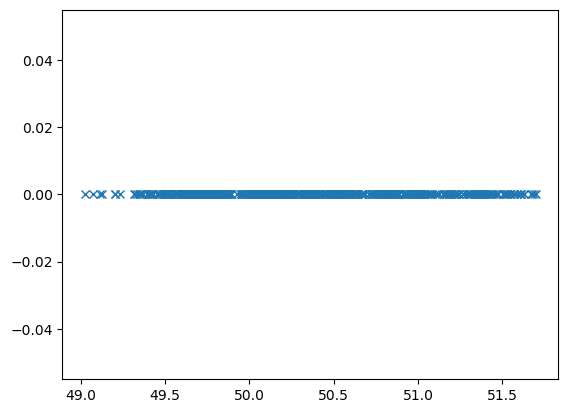

In [45]:
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(density_vals, np.zeros_like(density_vals) + val, 'x')
plt.show()

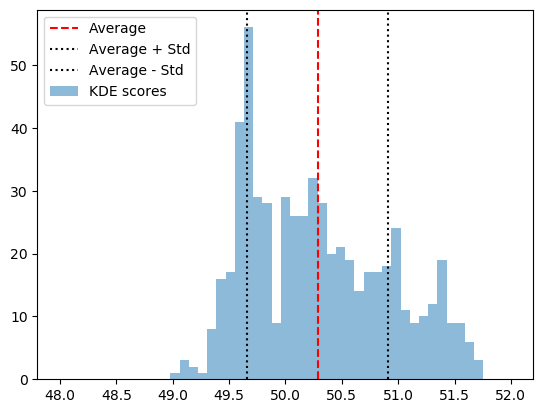

In [46]:
bins = np.linspace(48, 52, 50)
plt.hist(density_vals, bins, alpha=0.5, label='KDE scores')
plt.legend(loc='upper right')

# Calculate average and standard deviation
average = np.mean(density_vals)
std = np.std(density_vals)

# Plot average line
plt.axvline(x=average, color='red', linestyle='--', label='Average')

# Plot lines for standard deviation
plt.axvline(x=average + std, color='black', linestyle=':', label='Average + Std')
plt.axvline(x=average - std, color='black', linestyle=':', label='Average - Std')

plt.legend()

plt.show()

# Function to check if an image contains anomalies

Based on the previously found score of the KDE samples, its average and its standard deviation values, it can be built a function that maps the KDE scores to a probability value of an image being considered as an anomaly or not.

If the a given KDE score is outside the range of the standard deviation sum and subtraction to the average values, then that KDE score has more than 50% chance to be considered as an anomaly image.

In [47]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # if(value>leftMax):
    #     return rightMax
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [48]:
def map_kde2prob_list(input_list):
    threshold_NOanomaly = average_density          # The mean of the density values corresponding to the non-anomaly images
    std_dev_NOanomaly = stdev_density            # The std deviation of the density values corresponding to the non-anomaly images

    prob_score_list = []

    for i in range (len(input_list)):
        score_NOanomaly = input_list[i] - threshold_NOanomaly

        perc_NOanomaly = ranges_mapper(abs(score_NOanomaly), 0, std_dev_NOanomaly, 0, 50)
        if perc_NOanomaly<0:
            perc_NOanomaly = 0
        if perc_NOanomaly>100:
            perc_NOanomaly = 100
        prob_score_list.append(perc_NOanomaly)
    return prob_score_list

In [49]:
def map_kde2prob(value):
    threshold_NOanomaly = average_density          # The mean of the density values corresponding to the non-anomaly images
    std_dev_NOanomaly = stdev_density            # The std deviation of the density values corresponding to the non-anomaly images

    score_NOanomaly = value - threshold_NOanomaly

    perc_NOanomaly = ranges_mapper(abs(score_NOanomaly), 0, std_dev_NOanomaly, 0, 50)
    if perc_NOanomaly<0:
        perc_NOanomaly = 0
    if perc_NOanomaly>100:
        perc_NOanomaly = 100
    
    prob_score = perc_NOanomaly
    return prob_score

In [50]:
print(map_kde2prob(average_density+stdev_density))

49.999999999999766


# Validating the performance of the model with KDE score directly

We will use the validation data set to find the best threshold value for predicting an image as anomaly or non-anomaly.

In [51]:
def calc_kde_samples_for_val_eval(batch_images,batch_labels):   
    kde_score_list=[]
    labels_list = []
    for im in range(0, batch_images.shape[0]):
    # for im in range(1):
        label = batch_labels[im]
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder.predict([[img]])
        # print("The encoded_img shape is: ", encoded_img.shape)
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        density_val = kde.score_samples(encoded_img)
        kde_score_list.append(density_val)   
        labels_list.append(label)
    return kde_score_list, labels_list

In [52]:
kde_scores_list = []
labels_list = []
for i in range(len(validation_generator_for_threshold)):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_labels = next(val_crops_for_threshold)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    kde_scores, labels = calc_kde_samples_for_val_eval(images_in_batch,images_labels)
    kde_scores_list.append(kde_scores)
    labels_list.append(labels)
    
print("The list of kde scores list contains ", len(kde_scores_list), "batches of rec. errors")

The list of kde scores list contains  3 batches of rec. errors


In [53]:
print(kde_scores_list)

[[array([49.09942817]), array([49.72763568]), array([50.84972639]), array([50.47881571]), array([51.37865007]), array([50.4933984]), array([49.3021503]), array([49.0572674]), array([46.29300191]), array([46.77449642])], [array([51.08169262]), array([51.16367856]), array([49.98982493]), array([51.05573643]), array([49.89672326]), array([49.29017212]), array([45.93798546]), array([49.73438608]), array([51.32960684]), array([47.56790025])], [array([48.08335203]), array([47.4019305]), array([39.60001281]), array([46.09183701]), array([47.24054727]), array([41.1668]), array([46.58686407]), array([46.69060017]), array([46.34826198]), array([46.64204157])]]


In [54]:
kde_scores_validation = [item[0] for sublist in kde_scores_list for item in sublist]
y_true = [item for sublist in labels_list for item in sublist]
print("The kde scores list is: ", kde_scores_validation)
print("The ground truth labels are: ", y_true)

The kde scores list is:  [49.099428173576705, 49.72763567839343, 50.84972639165524, 50.47881571428303, 51.37865006677926, 50.493398404738755, 49.302150302002815, 49.05726739518682, 46.293001912231986, 46.774496417350555, 51.08169261919457, 51.16367855639201, 49.98982492609657, 51.055736425369126, 49.89672325979768, 49.290172120299445, 45.9379854551961, 49.73438608262956, 51.32960683873393, 47.567900253141296, 48.083352033784244, 47.40193049891009, 39.60001280603536, 46.09183701465492, 47.24054726708579, 41.16680000282252, 46.58686406724378, 46.690600173023235, 46.34826198277665, 46.64204157268865]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Let's compute the ROC and AUC score out of directly the KDE scores obtained from the images of the validation data set.

In [55]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, kde_scores_validation))

AUC =  0.09499999999999999


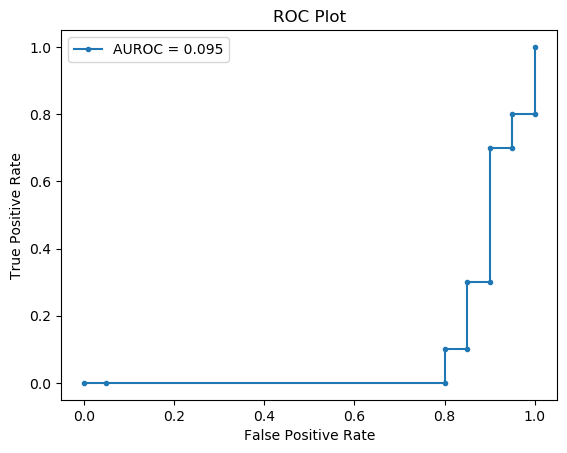

In [56]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, kde_scores_validation)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, kde_scores_validation))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [58]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.05 0.8  0.8  0.85 0.85 0.9  0.9  0.95 0.95 1.   1.  ]
The tpr is:  [0.  0.  0.  0.1 0.1 0.3 0.3 0.7 0.7 0.8 0.8 1. ]
The thresholds are:  [52.37865007 51.37865007 49.0572674  48.08335203 47.56790025 47.24054727
 46.77449642 46.34826198 46.29300191 46.09183701 45.93798546 39.60001281]


The best threshold value for this is:39.59637982, let's asses this.

In [59]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [60]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [61]:
best_threshold_approach1 = 39.59637982

In [62]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(kde_scores_validation, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[ 0 20]
 [ 0 10]]
The FPR values are:  1.0
The TPR values are:  1.0
Using the threshold =  39.59637982


# Validating the performance of the model with the mapping of the kde scores to a probability value

In [63]:
probs_list = map_kde2prob_list(kde_scores_validation)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [95.11279919521488, 44.805089597305326, 45.05345763822091, 15.350427188992684, 87.41038340490853, 16.518228832522656, 78.87853601348775, 98.48909154988664, 100, 100, 63.629627967443206, 70.19517309069737, 23.808618794251675, 61.5510207377852, 31.26432659037586, 79.83776506125265, 100, 44.264508064331174, 83.48293514087007, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [64]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, probs_list))

AUC =  0.9


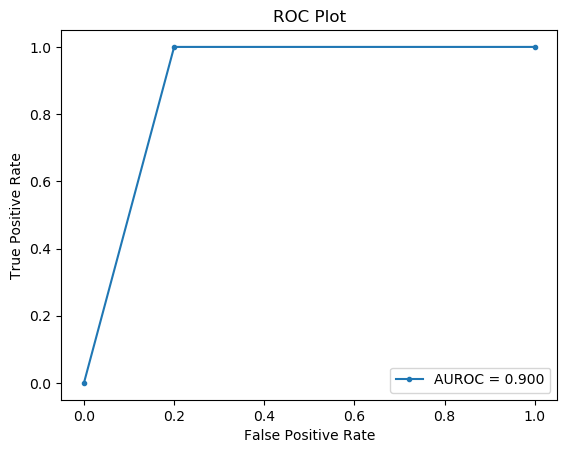

In [65]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, probs_list)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, probs_list))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [66]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.  0.2 1. ]
The tpr is:  [0. 1. 1.]
The thresholds are:  [101.         100.          15.35042719]


The best threshold in terms of FPR and TPR is 99.7 .  Let's asses that.

In [75]:
best_threshold_approach2 = 99.7

In [76]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list,  best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold =  ", best_threshold_approach2)

[[16  4]
 [ 0 10]]
The FPR values are:  0.2
The TPR values are:  1.0
Using the threshold =   99.7


# Evaluating the model. With the threhsold value of the direct reconstruction error

In [77]:
kde_scores_list_eval = []
labels_list_eval = []
for i in range(len(test_set_generator)):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_labels = next(test_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    kde_scores, labels = calc_kde_samples_for_val_eval(images_in_batch,images_labels)
    kde_scores_list_eval.append(kde_scores)
    labels_list_eval.append(labels)
    
print("The list of rec. error contains ", len(kde_scores_list_eval), "batches of rec. errors")

The list of rec. error contains  3 batches of rec. errors


In [78]:
print(kde_scores_list_eval)

[[array([48.99210696]), array([51.11216775]), array([51.22230389]), array([49.71149984]), array([50.74561223]), array([47.8189834]), array([48.80182063]), array([44.50761916]), array([47.55903104]), array([48.11452086])], [array([40.37550648]), array([50.21190453]), array([41.22214493]), array([48.90395854]), array([47.96144633]), array([49.83489656]), array([48.72451697]), array([47.5140479]), array([50.50458364]), array([49.94311767])], [array([47.33264818]), array([47.76854324]), array([45.49533559]), array([44.10555957]), array([46.24949396]), array([43.06307243]), array([45.7434014]), array([45.13237821]), array([48.3090015]), array([46.00077531])]]


In [79]:
kde_scores_evaluation= [item[0] for sublist in kde_scores_list_eval for item in sublist]
y_true = [item for sublist in labels_list_eval for item in sublist]
print("The kde scores list is: ", kde_scores_evaluation)
print("The ground truth labels are: ", y_true)

The kde scores list is:  [48.99210696022889, 51.11216775394201, 51.22230389293114, 49.71149983520966, 50.74561222780657, 47.818983403820276, 48.801820634977425, 44.507619161250474, 47.55903103655943, 48.11452086437855, 40.3755064789839, 50.21190452783889, 41.222144927459496, 48.9039585366328, 47.9614463264157, 49.83489656332906, 48.724516973643425, 47.51404790023159, 50.50458364110751, 49.943117670489215, 47.332648179538516, 47.768543238628155, 45.495335585298655, 44.10555956653472, 46.24949396171571, 43.06307242972851, 45.74340139500761, 45.13237820823702, 48.30900149727615, 46.000775312773015]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [80]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(kde_scores_evaluation, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[ 0 20]
 [ 0 10]]
The FPR values are:  1.0
The TPR values are:  1.0
Using the threshold =  39.59637982


In [81]:
def computePredList(probs_list, threshold_value):
    pred = 0
    pred_list =[]
    for i in range (len(probs_list)):
        if probs_list[i] > threshold_value:              # Working with a threshold of 50%
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list

In [82]:
y_pred = computePredList(kde_scores_evaluation, best_threshold_approach1)
print("The groudn truth is: ", np.array(y_true))
print("The predicted label is: ", y_pred)

The groudn truth is:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
The predicted label is:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [83]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [84]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 0 20]
 [ 0 10]]


Text(0.5, 23.52222222222222, 'Predicted label')

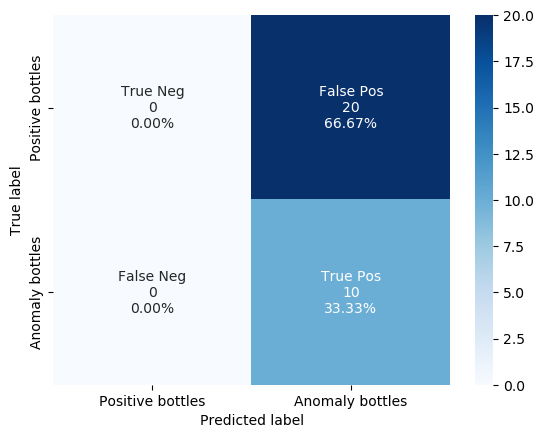

In [85]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [86]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  1.0
The TPR values are:  1.0


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [87]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.3333333333333333


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [88]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  1.0


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [89]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.0


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [90]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.3333333333333333


## The ROC curve

In [91]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [92]:
auc_score = roc_auc_score(y_true, kde_scores_evaluation)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, kde_scores_evaluation)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.175
The fpr is:  [0.   0.05 0.6  0.6  0.75 0.75 0.85 0.85 0.9  0.9  1.  ]
The tpr is:  [0.  0.  0.  0.1 0.1 0.2 0.2 0.8 0.8 1.  1. ]
The thresholds are:  [52.22230389 51.22230389 48.72451697 48.3090015  47.8189834  47.76854324
 47.5140479  45.13237821 44.50761916 43.06307243 40.37550648]


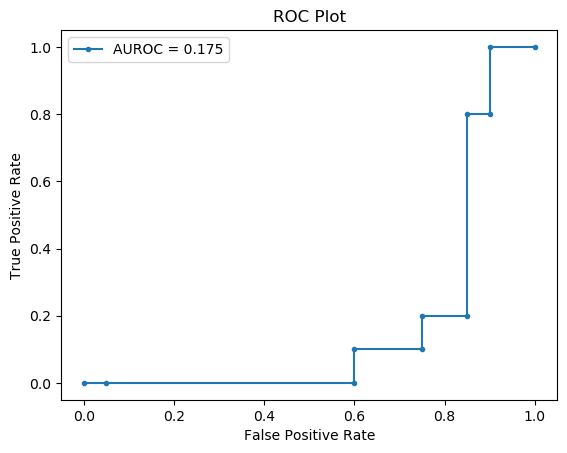

In [93]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Evaluating the model. With the threhsold value computed from a probability value upon the reconstruction errors

In [94]:
probs_list = map_kde2prob_list(kde_scores_evaluation)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [100, 66.07011811930582, 74.88996960789383, 46.097269819258585, 36.71585409199117, 100, 100, 100, 100, 100, 100, 6.02418287712339, 100, 100, 100, 36.21549235565736, 100, 100, 17.413957741694755, 27.54899921504192, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [99]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach2)

[[ 8 12]
 [ 0 10]]
The FPR values are:  0.6
The TPR values are:  1.0
Using the threshold =  99.7


In [100]:
y_pred = computePredList(probs_list, best_threshold_approach2)
print("The groudn truth is: ", np.array(y_true))
print("The predicted label is: ", y_pred)

The groudn truth is:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
The predicted label is:  [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [101]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [102]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 8 12]
 [ 0 10]]


Text(0.5, 23.52222222222222, 'Predicted label')

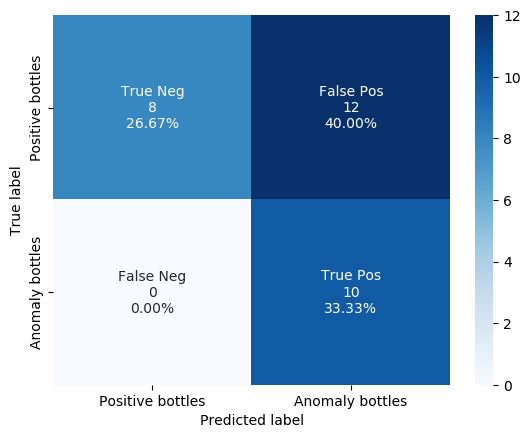

In [103]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [104]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.6
The TPR values are:  1.0


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [105]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.45454545454545453


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [106]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  1.0


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [107]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.4


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [108]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.6


## The ROC curve

In [109]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [110]:
auc_score = roc_auc_score(y_true, probs_list)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, probs_list)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.700
The fpr is:  [0.  0.6 1. ]
The tpr is:  [0. 1. 1.]
The thresholds are:  [101.         100.           6.02418288]


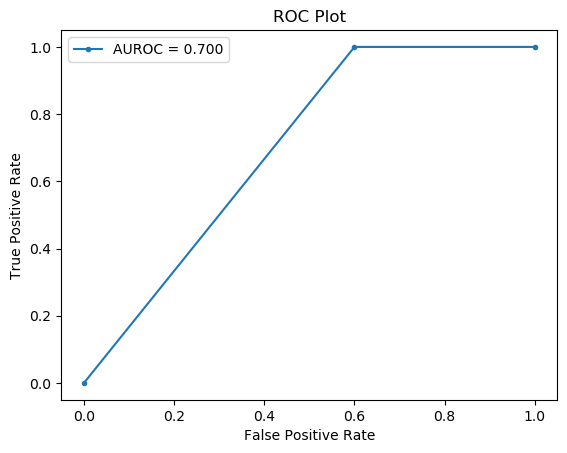

In [111]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()